## Домашнее задание «Сохранение результатов эксперимента»

# 1. Понимание бизнеса

## 1.1 Цель
Предсказать качество вина

## 1.2 Описание
Имеются данные по красному и белому ваниантам португальского вина "Vinho Verde" ([Cortez et al., 2009]).  
Доступны только физико-химические переменные, как входные, и сенсорные, обозначающие качество вина,   
как выходные переменные.  
Нет данных о сортах винограда, марке вина, отпускной цене вина и т. д.



# 2. Data Understanding

## 2.1 Import Libraries

In [84]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer, scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
ohe = OneHotEncoder()

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8, 6

## 2.2 Вспомогательные функции

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title('Skew: ' + str(round(float(df[var_name].skew()), 0)) + '. ' + var_name) # + ' ' + var_name )) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = wine.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr,
        cmap = cmap,
        square=True,
        cbar_kws={ 'shrink' : .9 },
        ax=ax,
        annot = True,
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )

def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame(
        model.feature_importances_  ,
        columns = [ 'Importance' ] ,
        index = X.columns
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

## 2.3 Загрузка данных

In [4]:
import os

folder = 'D:\Git_repos\wine_quality\data'
filename= 'winequalityN.csv'
fullpath = os.path.join(folder, filename)

wine = pd.read_csv(fullpath)

print ('Dataset wine:' , wine.shape)

Dataset wine: (6497, 13)


## 2.4 Статистика и визуализации

In [5]:
wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание переменных**

Входные переменные (на основе физико-химических испытаний):  
 0. type: вид вина (белое или красное, качественная)
 1. fixed acidity:  фиксированная кислотность
 2. volatile acidity:  летучая кислотность
 3. citric acid:  лимонная кислота
 4. residual sugar:  остаточный сахар
 5. chlorides:  хлориды
 6. free sulfur dioxide:  свободный диоксид серы
 7. total sulfur dioxide:  общий диоксид серы
 8. density:  плотность
 9. pH:  водородный показатель рН
 10. sulphates:  сульфаты
 11. alcohol:  алкоголь

Выходная переменная (на основе вкусовых ощущений):  
 12. quality: качество (оценка от 0 до 10)


[Больше информации на сайте Kaggle](https://www.kaggle.com/datasets/rajyellow46/wine-quality/)

### 2.4.1 Тип данных у параметров

Переменные имеют числовой тип, кроме переменной "type", указывающей вид вина.  
Эта качественная переменная имеет два значения 'white' и 'red'.    
При предобработке данных будет перекодирована в числовые значения 0 и 1.


In [6]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [7]:
wine['type'].unique()

array(['white', 'red'], dtype=object)

### 2.4.2 Основные статистические характеристики численных переменных

In [8]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### 2.4.2 Тепловая карта корреляции для понимания того, какие переменные важны

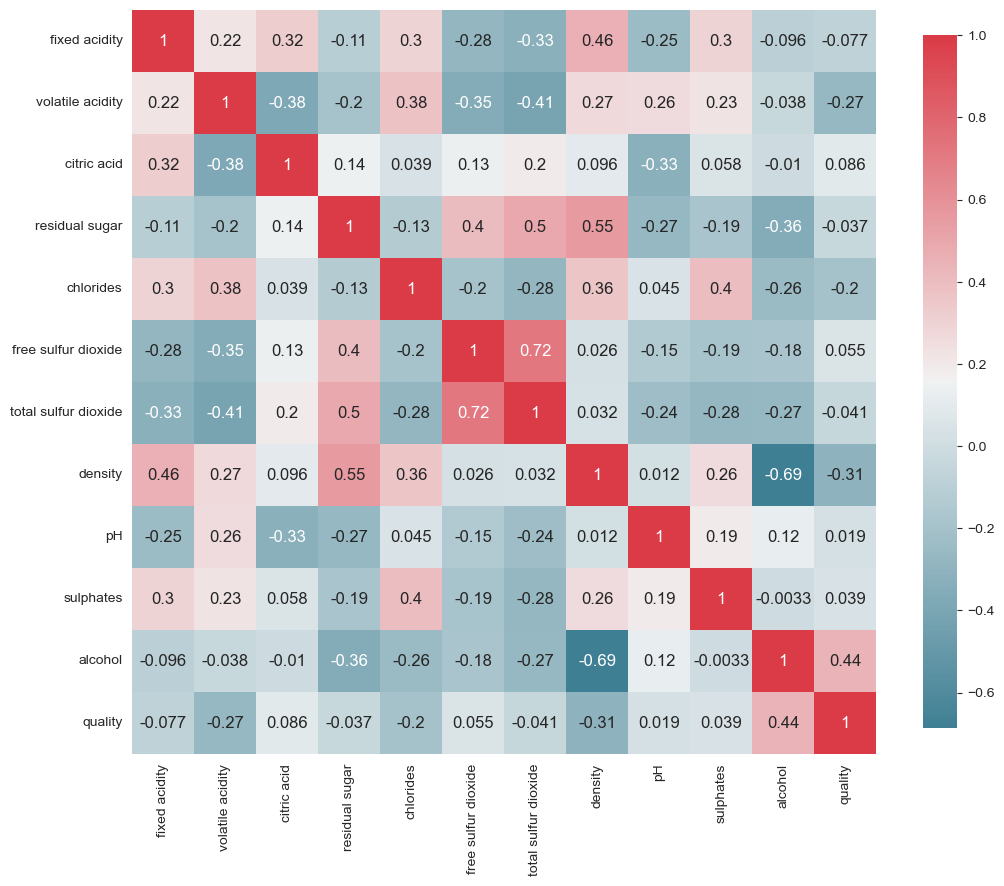

In [9]:
plot_correlation_map(wine)

Наибольшее влияние оказывают переменные alcohol, density, volatile acidity, chlorides

### 2.4.3 Подробнее рассмотрим взаимосвязь между признаками

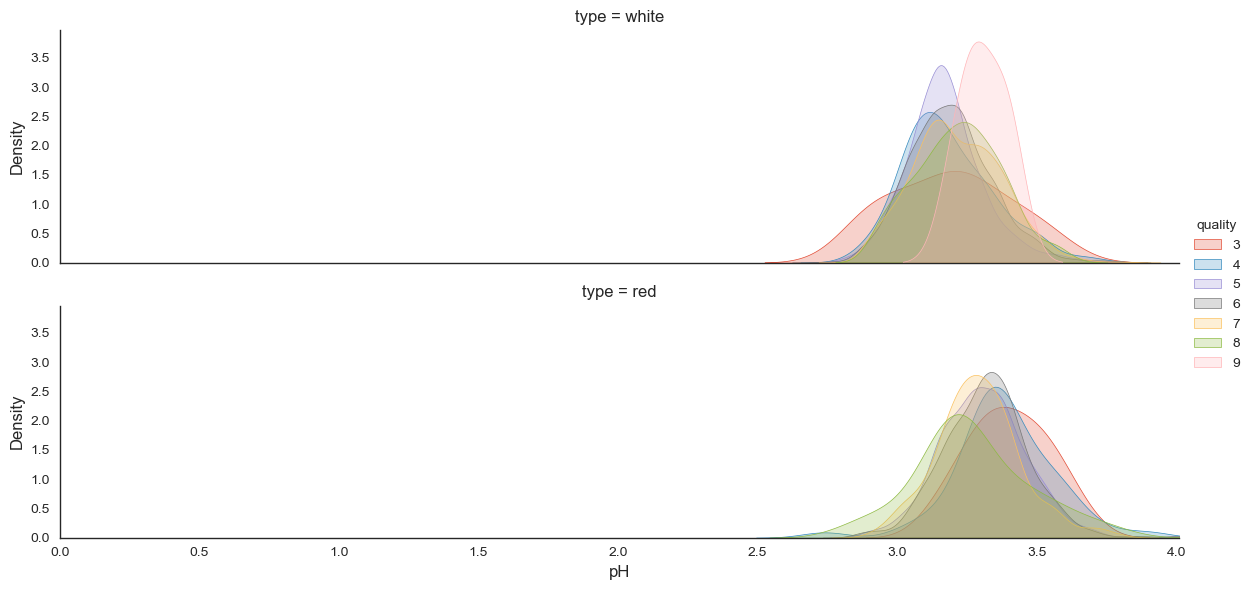

In [10]:
 plot_distribution(wine, var = 'pH' , target = 'quality' , row = 'type' )

In [11]:
list(wine)[1:12]

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [12]:
list(wine)[1:]

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

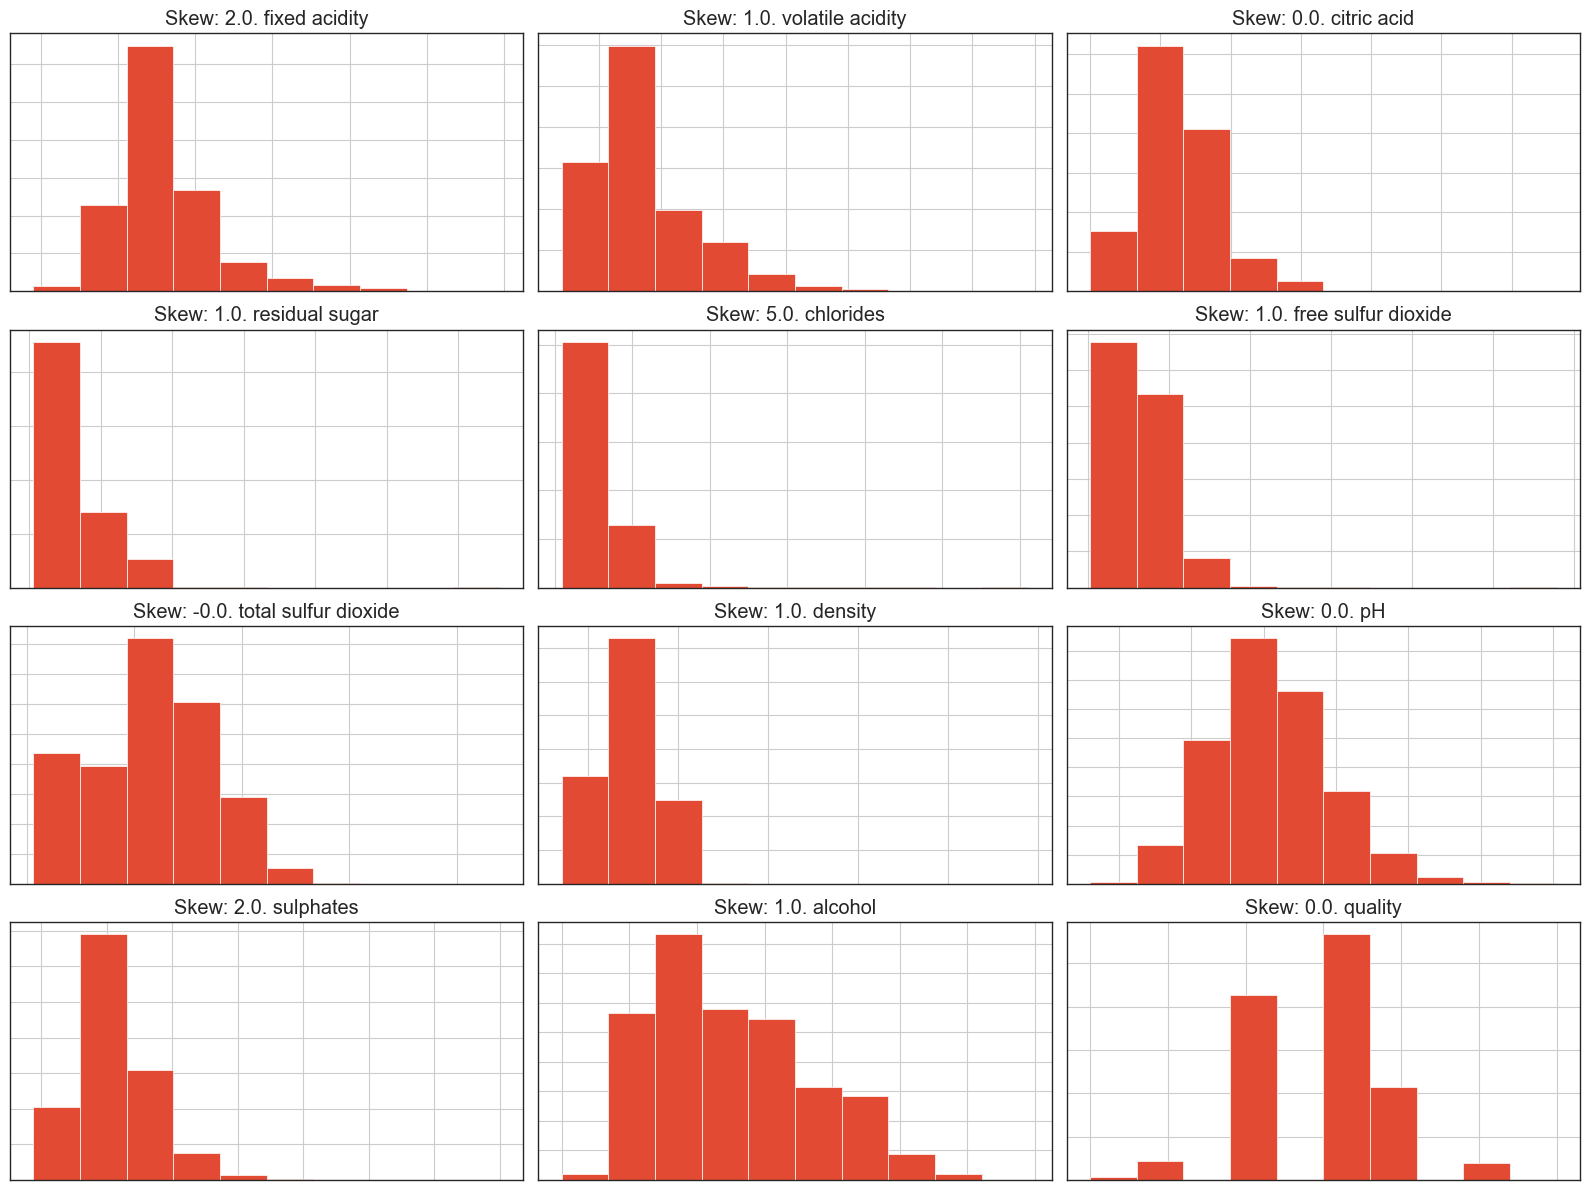

In [13]:
plot_histograms(wine, list(wine)[1:13], 4, 3)

<AxesSubplot:title={'center':'Распределение параметра alcohol'}>

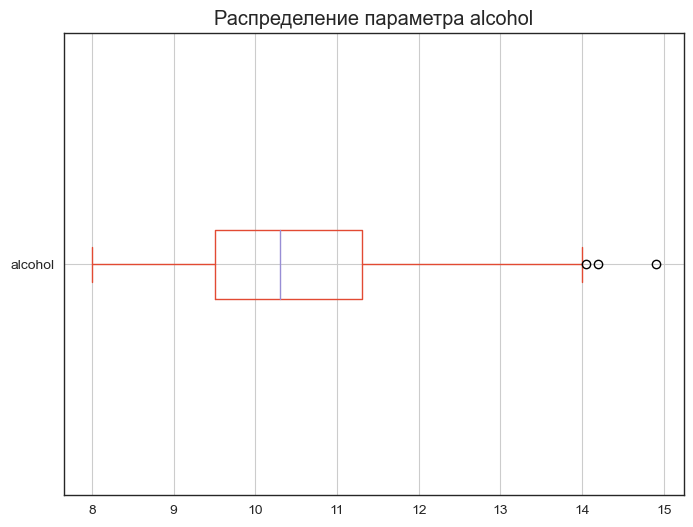

In [14]:
# Проверю на выбросы столбец 'alcohol'
wine['alcohol'].plot(kind='box', vert=False, title='Распределение параметра alcohol', grid=True)

In [15]:
def plot_boxes(df, variables, n_rows, n_cols):
    fig = plt.figure(figsize = ( 16 , 12 ))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows, n_cols, i+1)
        df[var_name].plot(kind='box', vert=False, ax=ax, grid=True)
        ax.set_title('Распределение параметра ' + var_name)
        ax.set_xticklabels([], visible=False)
        ax.set_yticklabels([],  visible=False)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

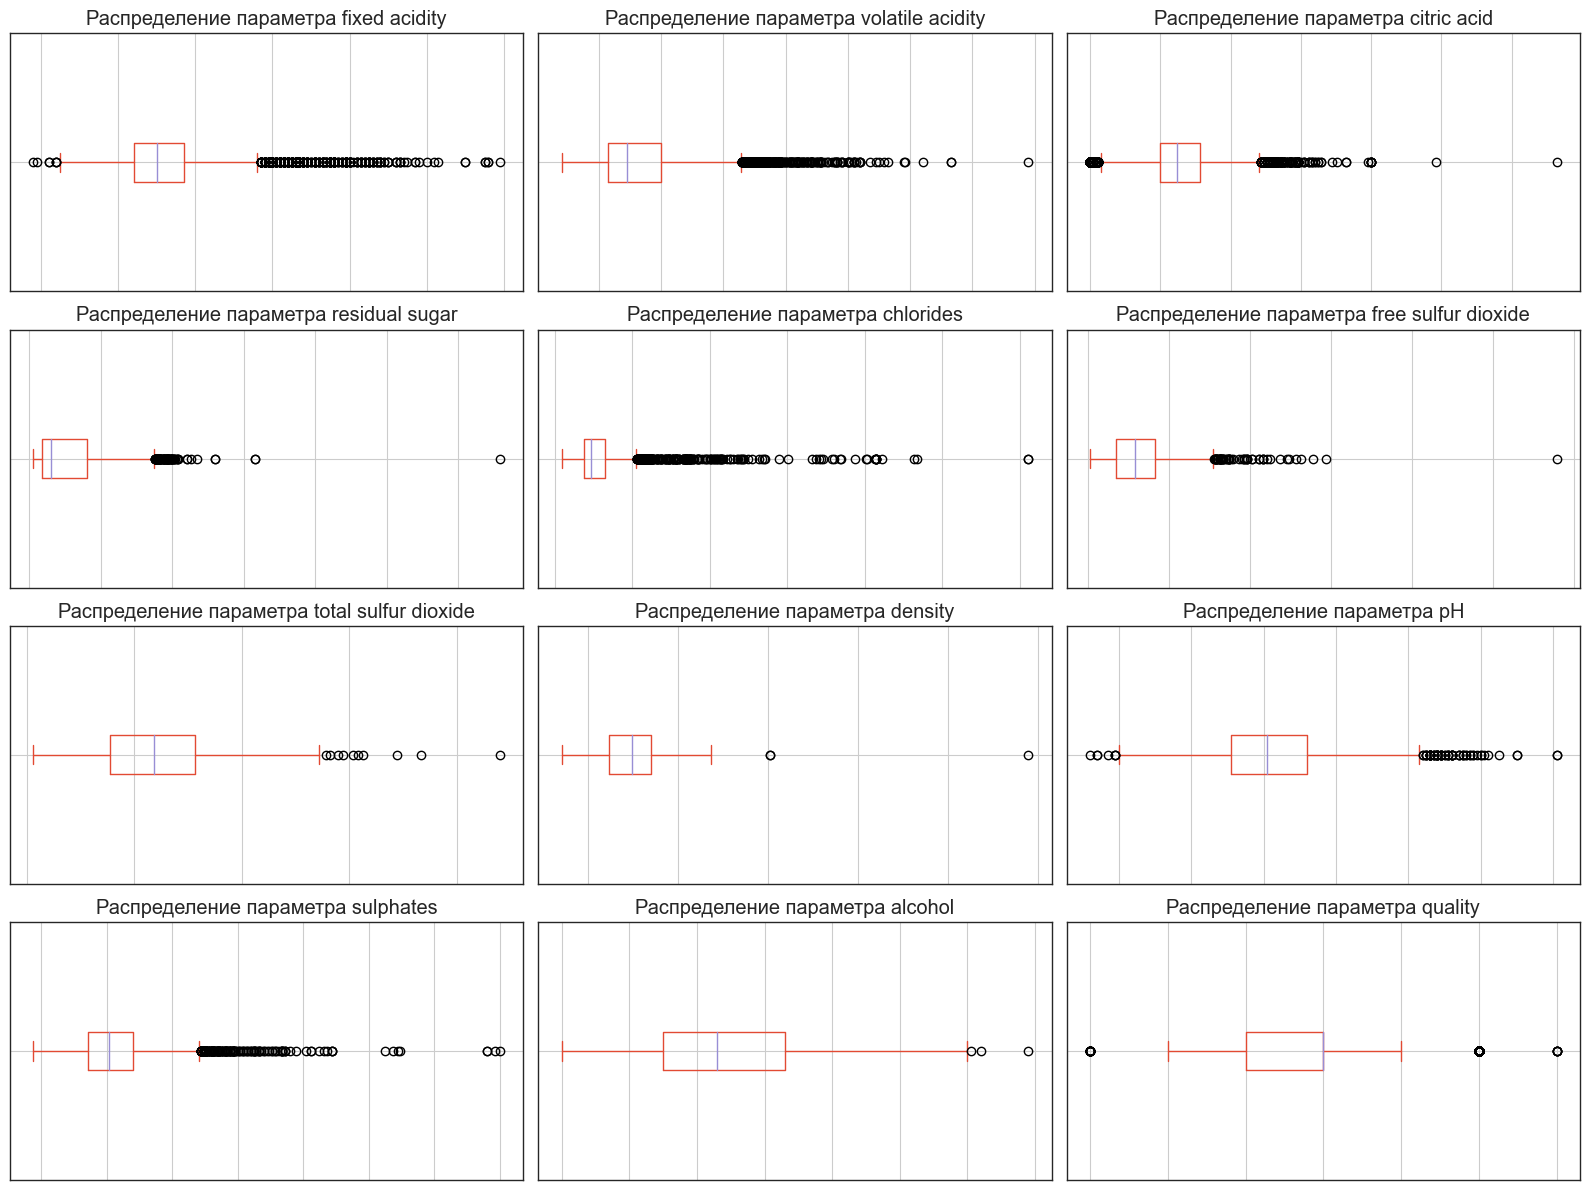

In [16]:
plot_boxes(wine, list(wine)[1:], 4, 3)

In [17]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [18]:
wine[['type', 'quality', 'alcohol']].groupby(['type', 'quality']).count()

alcohol
type  quality         
red   3             10
      4             53
      5            681
      6            638
      7            199
      8             18
white 3             20
      4            163
      5           1457
      6           2198
      7            880
      8            175
      9              5

In [25]:
wine[['type', 'quality', 'alcohol']].pivot_table(index= 'type', columns= 'quality', values= 'alcohol',
                                                 aggfunc= 'count', fill_value= 0, margins= True)

quality,3,4,5,6,7,8,9,All
type,,,,,,,,
red,10,53,681,638,199,18,0,1599
white,20,163,1457,2198,880,175,5,4898
All,30,216,2138,2836,1079,193,5,6497


In [26]:
wine[['type', 'quality', 'citric acid']].pivot_table(index= 'type', columns= 'quality', values= 'citric acid',
                                                 aggfunc= 'max', fill_value= 0)

quality,3,4,5,6,7,8,9
type,,,,,,,
red,0.66,1.00,0.79,0.78,0.76,0.72,0.00
white,0.47,0.88,1.00,1.66,0.74,0.74,0.49


In [27]:
wine.loc[wine.quality == 9]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
774,white,9.1,0.27,0.45,10.6,0.035,28.0,124.0,0.99700,3.20,0.46,10.4,9
820,white,6.6,0.36,0.29,1.6,0.021,24.0,85.0,0.98965,3.41,0.61,12.4,9
827,white,7.4,0.24,0.36,2.0,0.031,27.0,139.0,0.99055,3.28,0.48,12.5,9
876,white,6.9,0.36,0.34,4.2,0.018,57.0,119.0,0.98980,3.28,0.36,12.7,9
1605,white,7.1,0.26,0.49,2.2,0.032,31.0,113.0,0.99030,3.37,0.42,12.9,9


In [28]:
wine.loc[(wine.quality == 3) & (wine['type'] == 'red')]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
5357,red,11.6,0.580,0.66,2.20,0.074,10.0,47.0,1.00080,3.25,0.57,9.00,3
5415,red,10.4,0.610,0.49,2.10,0.200,5.0,16.0,0.99940,3.16,0.63,8.40,3
5588,red,7.4,1.185,0.00,4.25,0.097,5.0,14.0,0.99660,3.63,0.54,10.70,3
5730,red,10.4,0.440,0.42,1.50,0.145,34.0,48.0,0.99832,3.38,0.86,9.90,3
5797,red,8.3,1.020,0.02,3.40,0.084,6.0,11.0,0.99892,3.48,0.49,11.00,3
6197,red,7.6,1.580,0.00,2.10,0.137,5.0,9.0,0.99476,3.50,0.40,10.90,3
6272,red,6.8,0.815,0.00,1.20,0.267,16.0,29.0,0.99471,3.32,0.51,9.80,3
6367,red,7.3,0.980,0.05,2.10,0.061,20.0,49.0,0.99705,3.31,0.55,9.70,3
6376,red,7.1,0.875,0.05,5.70,0.082,3.0,14.0,0.99808,3.40,0.52,10.20,3
6403,red,6.7,0.760,0.02,1.80,0.078,6.0,12.0,0.99600,3.55,0.63,9.95,3


In [29]:
wine.loc[(wine.quality == 3) & (wine['type'] == 'white')]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
251,white,8.5,0.260,0.21,16.20,0.074,41.0,197.0,0.99800,3.02,0.50,9.8,3
253,white,5.8,0.240,0.44,3.50,0.029,5.0,109.0,0.99130,3.53,0.43,11.7,3
294,white,9.1,0.590,0.38,1.60,0.066,34.0,182.0,0.99680,3.23,0.38,8.5,3
445,white,7.1,0.320,0.32,11.00,0.038,16.0,66.0,0.99370,3.24,0.40,11.5,3
740,white,6.9,0.390,0.40,4.60,0.022,5.0,19.0,0.99150,3.31,0.37,12.6,3
873,white,10.3,0.170,0.47,1.40,0.037,5.0,33.0,0.99390,2.89,0.28,9.6,3
1034,white,7.9,0.640,0.46,10.60,0.244,33.0,227.0,0.99830,2.87,0.74,9.1,3
1229,white,8.3,0.330,0.42,1.15,0.033,18.0,96.0,0.99110,3.20,0.32,12.4,3
1417,white,8.6,0.550,0.35,15.55,0.057,35.5,366.5,1.00010,3.04,0.63,11.0,3
1484,white,7.5,0.320,0.24,4.60,0.053,8.0,134.0,0.99580,3.14,0.50,9.1,3


<AxesSubplot:title={'center':'Распределение параметра "total sulfur dioxide"'}>

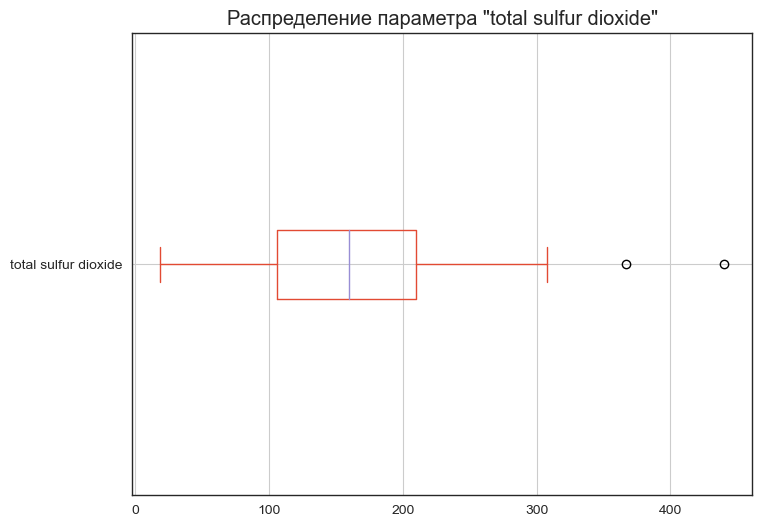

In [30]:
# Проверю на выбросы переменную 'total sulfur dioxide' для белого вина низкого качества (3)
wine.loc[(wine.quality == 3) & (wine['type'] == 'white')]['total sulfur dioxide'].plot(kind='box', vert=False, title='Распределение параметра "total sulfur dioxide"', grid=True)

In [32]:
# Возможно, это выбросы, а может - причина низкого качества вина:
wine.loc[(wine.quality == 3) & (wine['type'] == 'white') & (wine['total sulfur dioxide'] > 350)]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1417,white,8.6,0.55,0.35,15.55,0.057,35.5,366.5,1.00010,3.04,0.63,11.0,3
4745,white,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3


# 3. Data Preparation

## 3.1 Категориальную переменную 'type' преобразую в числовую

In [33]:
wine2 = wine.copy()
wine2

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [37]:
# здесь белое вино кодируется 1, красное  - 0.
le.fit(wine2['type'])
wine2['types'] = le.transform(wine['type']) 
wine2.drop(columns= 'type').head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,types
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1


In [42]:
# второй вариант. Здесь белое вино кодируется 0, красное 1.
types = pd.Series( np.where(wine['type'] == 'red' , 1 , 0 ) , name = 'types' )

wine3 = pd.concat([types, wine], axis=1).drop(columns= 'type')
wine3.head(3)

,types,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


## 3.2 Устраняю строки с пропущенными значениями

In [43]:
# Считаю строки с пропущенными значениями
wine3.isnull().sum()

types                    0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [74]:
# Доля строк с пропущенными значениями
null_ = 0
for row in range(wine3.shape[0]):
    if wine3.iloc[row, :].isnull().sum() != 0:
        null_ += 1

print(f'Строк с пропусками: {null_}.')
print(f'Если удалить все пропуски, будет потеряно\
{null_ / wine3.shape[0] * 100: .2f} % данных.')

Строк с пропусками: 34.
Если удалить все пропуски, будет потеряно 0.52 % данных.


Удаляю строки с пропущенными значениями, т.к. потеря данных при этом незначительна.

In [44]:
wine_cl = wine3.dropna().reset_index(drop=True)
wine_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6463 entries, 0 to 6462
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   types                 6463 non-null   int32  
 1   fixed acidity         6463 non-null   float64
 2   volatile acidity      6463 non-null   float64
 3   citric acid           6463 non-null   float64
 4   residual sugar        6463 non-null   float64
 5   chlorides             6463 non-null   float64
 6   free sulfur dioxide   6463 non-null   float64
 7   total sulfur dioxide  6463 non-null   float64
 8   density               6463 non-null   float64
 9   pH                    6463 non-null   float64
 10  sulphates             6463 non-null   float64
 11  alcohol               6463 non-null   float64
 12  quality               6463 non-null   int64  
dtypes: float64(11), int32(1), int64(1)
memory usage: 631.3 KB


## 3.3 Отделяем данные для обучения и для проверки

In [46]:
# Выделяю столбец quality в целевую переменную y.
X = wine_cl.drop(columns=['quality'])
y = wine_cl['quality']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Моделирование

<b>4.1</b> Модель: LogisticRegression(), нормализация: StandardScaler()

In [48]:
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

In [49]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions[:10]

array([6, 5, 6, 6, 6, 5, 6, 5, 6, 7], dtype=int64)

In [50]:
model.score(X_train, y_train) , model.score(X_test, y_test)

(0.5458413926499033, 0.5382830626450116)

<b>4.2</b> Модель: LogisticRegression(), нормализация: Normalizer()

In [51]:
model_norm = make_pipeline(
    Normalizer(),
    LogisticRegression(max_iter=1000)
)

In [52]:
model_norm.fit(X_train, y_train)
predictions = model_norm.predict(X_test)
predictions[:10]

array([6, 6, 6, 6, 6, 6, 6, 5, 6, 6], dtype=int64)

In [53]:
model_norm.score(X_train, y_train) , model_norm.score(X_test, y_test)

(0.45589941972920695, 0.42846094354215003)

<b>4.3</b> Модель: DecisionTreeClassifier(), нормализация: Normalizer()

In [54]:
dtc_norm = make_pipeline(
    Normalizer(),
    DecisionTreeClassifier()
)

In [55]:
dtc_norm.fit(X_train, y_train)
predictions = dtc_norm.predict(X_test)
predictions[:10]

array([6, 6, 4, 6, 6, 5, 5, 5, 6, 7], dtype=int64)

In [56]:
dtc_norm.score(X_train, y_train) , dtc_norm.score(X_test, y_test)

(1.0, 0.5622583139984532)

<b>4.4</b> Модель: DecisionTreeClassifier(), нормализация: StandardScaler()

In [57]:
dtc_StSc = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier()
)

In [58]:
dtc_StSc.fit(X_train, y_train)
predictions = dtc_StSc.predict(X_test)
predictions[:10]

array([5, 6, 7, 6, 6, 5, 6, 6, 6, 6], dtype=int64)

In [59]:
dtc_StSc.score(X_train, y_train) , dtc_StSc.score(X_test, y_test)

(1.0, 0.5614849187935035)

Первая итерация построения модели.  
Удалены строки с отсутстующими значениями с потерей 0,52% данных, что посчитал приемлемым.  
Перед обучением модели данные нормализованы с помощью StandardScaler() и Normalizer().  
Классификация с помощью дерева решений с установками по умолчанию  и нормализацией данных через Normalizer на тренировочной выборке показывает скор = 1. На тестовой показывает низкий результат, 0.56. Произошло переобучение.  
Необходимо подобрать параметры модели.  
В случае отсутствия улучшения результата следует вернуться к этапу предобработки данных, чтобы убрать взаимосвязанные данные и выбросы на них.

In [60]:
rfc_norm = make_pipeline(
    Normalizer(),
    RandomForestClassifier()
)

rfc_norm.fit(X_train, y_train)
predictions = rfc_norm.predict(X_test)

rfc_norm.score(X_train, y_train) , rfc_norm.score(X_test, y_test)

(1.0, 0.654292343387471)

In [61]:
predictions[:10]

array([5, 6, 5, 6, 6, 5, 6, 6, 6, 6], dtype=int64)

In [ ]:
# !!! Sample !!!!
clf_countvec = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', LogisticRegression())]
)

params_ccntv = {
    'vect__analyzer': ['word'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'clf__C': np.logspace(-3,3,7),
    }

scores=['accuracy', 'f1']

grid_ccntv = GridSearchCV(
    clf_countvec,
    param_grid=params_ccntv,
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1,
    verbose=1
)

In [65]:
rfc_n = Pipeline(
   [('norm', Normalizer()),
    ('rfc', RandomForestClassifier())]
)

In [66]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 15, num = 10)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]

param_dist = {'rfc__n_estimators': n_estimators,
               'rfc__max_features': max_features,
               'rfc__max_depth': max_depth,
               'rfc__min_samples_split': min_samples_split,
               'rfc__min_samples_leaf': min_samples_leaf,
               'rfc__bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc_n,
                        param_dist,
                        n_iter = 100,
                        cv = 3,
                        verbose = 1,
                        n_jobs=-1,
                        random_state=42)
rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'rfc__n_estimators': 500,
 'rfc__min_samples_split': 23,
 'rfc__min_samples_leaf': 2,
 'rfc__max_features': 'log2',
 'rfc__max_depth': 15,
 'rfc__bootstrap': False}

In [81]:
rfc_norm = make_pipeline(
    Normalizer(),
    RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_split=23, min_samples_leaf=2, max_features='log2', bootstrap=False, random_state=42)
)

In [68]:
rfc_norm.fit(X_train, y_train)
predictions = rfc_norm.predict(X_test)

rfc_norm.score(X_train, y_train) , rfc_norm.score(X_test, y_test)

(0.8845261121856867, 0.6249033255993813)

Посмотрю, можно ли ешё улучшить модель.  
Проанализирую получившиеся варианту парметров и  
воспользуюсь GridSearchCV().


In [69]:
# Строю датафрейм наборов параметров, результатов RandomizedSearchCV

rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time',
            'std_fit_time',
            'mean_score_time',
            'std_score_time',
            'params',
            'split0_test_score',
            'split1_test_score',
            'split2_test_score',
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_rfc__n_estimators,param_rfc__min_samples_split,param_rfc__min_samples_leaf,param_rfc__max_features,param_rfc__max_depth,param_rfc__bootstrap,mean_test_score,rank_test_score
0,500,23,2,log2,15,False,0.605224,1
1,400,12,2,log2,13,True,0.604449,2
2,900,28,7,log2,15,False,0.594392,3
3,900,7,7,sqrt,15,True,0.594005,4
4,600,34,2,sqrt,13,False,0.591877,5
5,300,12,12,sqrt,12,False,0.585494,6
6,1000,50,2,sqrt,15,False,0.584914,7
7,900,44,7,sqrt,15,False,0.582012,8
8,1000,28,7,sqrt,10,False,0.581626,9
9,700,7,2,sqrt,9,True,0.580465,10


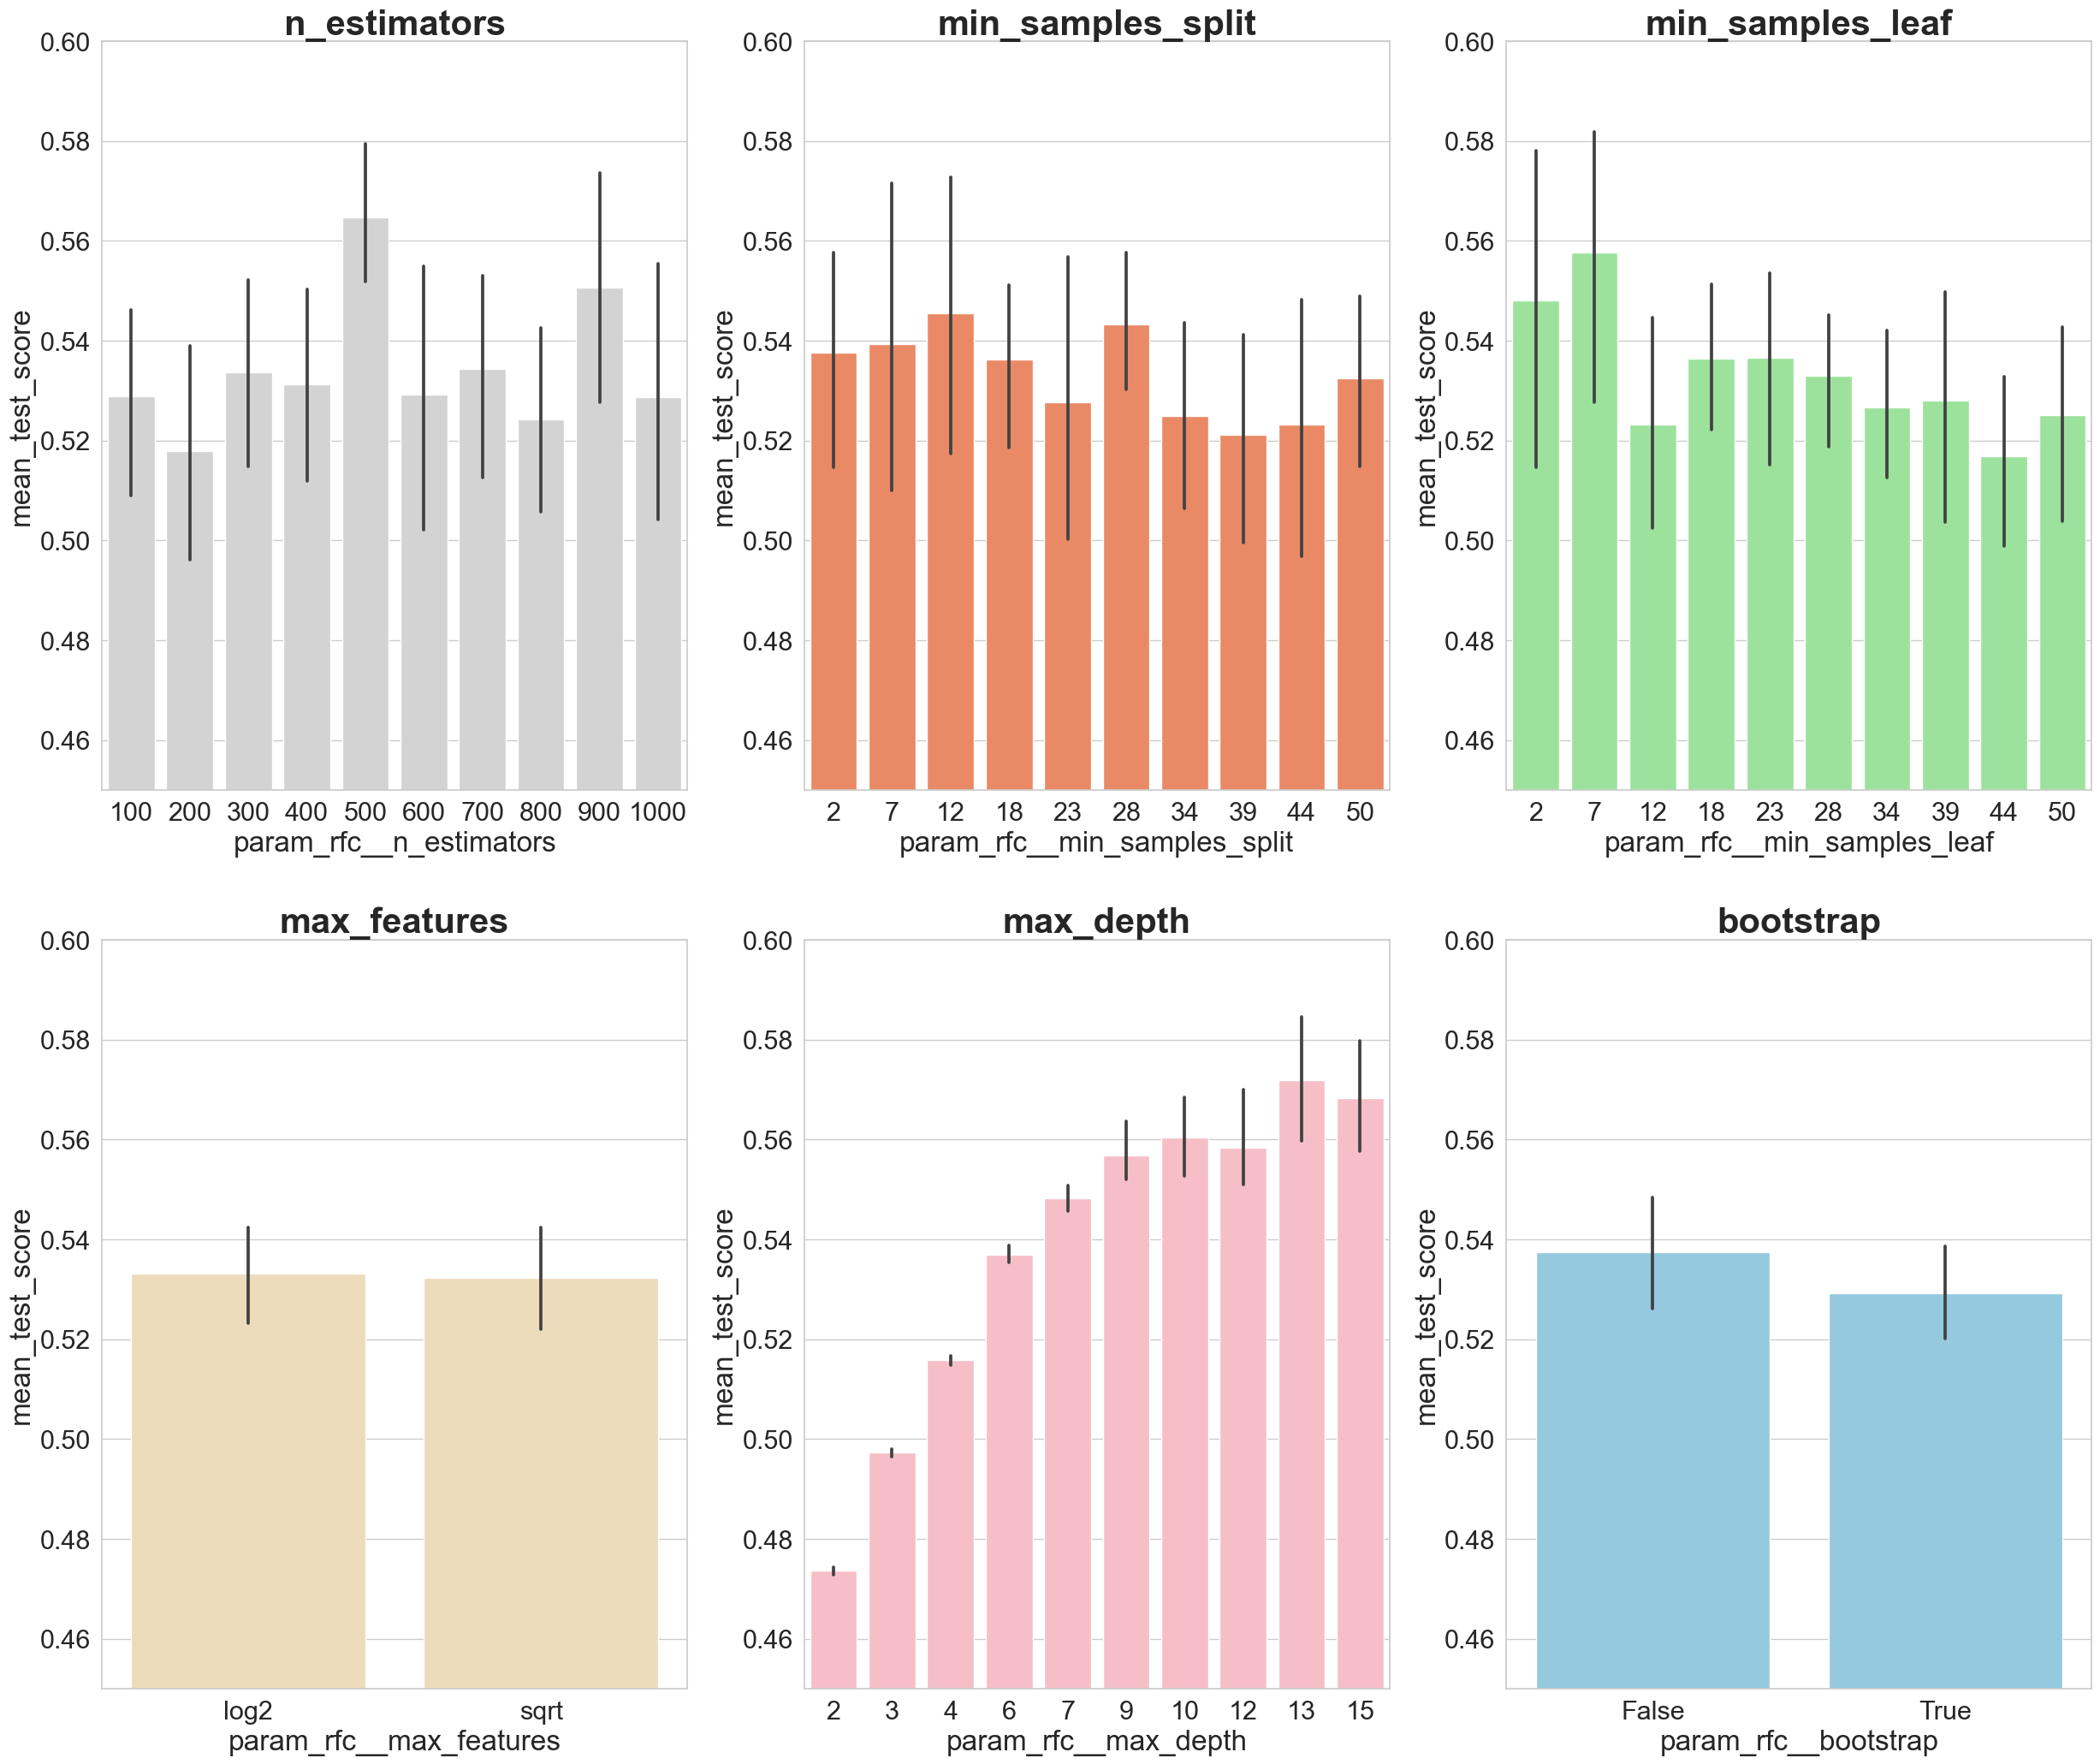

In [73]:
# посторою столбатые диаграммы параметров, где по оси y будут средние оценки модели для этих параметров
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_rfc__n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.45,.60]), axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_rfc__min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.45,.60]), axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_rfc__min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.45,.60]), axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_rfc__max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.45,.60]), axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_rfc__max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.45,.60]), axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_rfc__bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.45,.60])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

<b>Анализ значений параметров модели</b>  
* <b>max_features</b> и <b>bootstrap</b> в среднем, влияют на модель, практически одинаково  
* <b>n_estimators</b> лучшие показатели при значениях парамета = 500; 900  
* <b>min_samples_split</b> значения 12 и 28 показывают себя лучше  
* <b>min_samples_leaf</b> для этого парметра отмечу значения 2 и 7  
* <b>max_depth</b> с увеличением парметра росло качество модели.   
Лучшее у значения 13, но можно посмотреть 15. А ещё, возможно, 17.



In [77]:
from sklearn.model_selection import GridSearchCV

n_estimators = [500, 900]
max_features = ['log2', 'sqrt']
max_depth = [13,15,17]
min_samples_split = [12,28]
min_samples_leaf = [2,7]
bootstrap = [True, False]

param_grid = {'rfc__n_estimators': n_estimators,
               'rfc__max_features': max_features,
               'rfc__max_depth': max_depth,
               'rfc__min_samples_split': min_samples_split,
               'rfc__min_samples_leaf': min_samples_leaf,
               'rfc__bootstrap': bootstrap}
gs = GridSearchCV(rfc_n, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
rfc_best = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 96 candidates, totalling 288 fits


{'rfc__bootstrap': False,
 'rfc__max_depth': 17,
 'rfc__max_features': 'sqrt',
 'rfc__min_samples_leaf': 2,
 'rfc__min_samples_split': 12,
 'rfc__n_estimators': 500}

In [85]:
rfc_best

Pipeline(steps=[('norm', Normalizer()),
                ('rfc',
                 RandomForestClassifier(bootstrap=False, max_depth=17,
                                        max_features='sqrt', min_samples_leaf=2,
                                        min_samples_split=12,
                                        n_estimators=500))])

In [82]:
rfc_17 = make_pipeline(
    Normalizer(),
    RandomForestClassifier(n_estimators=500, max_depth=17, min_samples_split=12, min_samples_leaf=2, 
                           max_features='sqrt', bootstrap=False, n_jobs=-1, random_state=42)
)

In [83]:
rfc_17.fit(X_train, y_train)
predictions = rfc_17.predict(X_test)

rfc_17.score(X_train, y_train) , rfc_17.score(X_test, y_test)

(0.9531914893617022, 0.6481051817478731)